# Align two single-cell spatial MERFISH brain sections using LDDMM with cell density only (original LDDMM()). 
(Using initial affine transformation of the image. )

Data source: Vizgen Data Release V1.0. May 2021 (https://info.vizgen.com/mouse-brain-map?submissionGuid=955163f1-3119-42d9-bcbf-e0255e6e7d17) 

Dataset used: Slice 2 Replicate 2, Slice 2 Replicate 3 

Code: Iris Kwon (skwon38@jh.edu)


# Import dependencies

In [1]:
#import STalign
from STalign import STalign
#dir(STalign)
import os
import matplotlib.pyplot as plt
##### %%time
import torch
import copy
from torch.nn.functional import grid_sample
import pandas as pd
import scanpy as sc
import numpy as np

Run code below to check that matplotlib widget is working: 

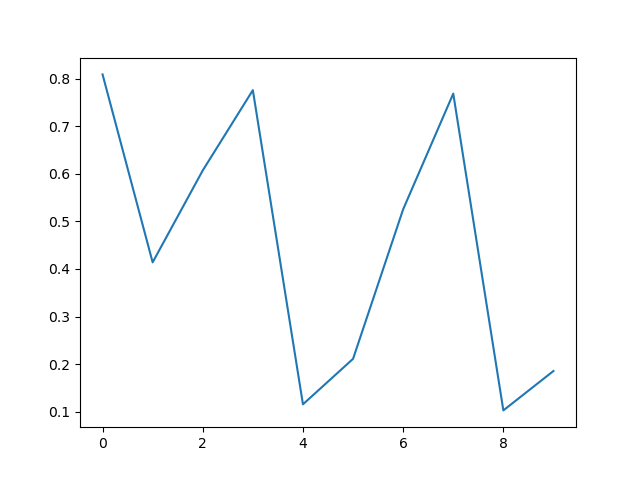

In [2]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
ax.plot(np.random.rand(10))
plt.show()

In [3]:
# make plots bigger
plt.rcParams["figure.figsize"] = (8,6)

In [4]:
dir(STalign)

['LDDMM',
 'LDDMM_3D_to_slice',
 'L_T_from_points',
 'Line2D',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'analyze3Dalign',
 'build_transform',
 'build_transform3D',
 'calculate_tre',
 'clip',
 'cm',
 'copy',
 'defaultdict',
 'download_aba_image_labels',
 'download_aba_ontology',
 'exists',
 'extent_from_x',
 'glob',
 'go',
 'grid_sample',
 'interp',
 'interp3D',
 'join',
 'make_scree',
 'makedirs',
 'normalize',
 'np',
 'nrrd',
 'os',
 'pd',
 'plot_brain_regions',
 'plot_subset_brain_regions',
 'plt',
 'px',
 'rasterize',
 'rasterizePCA',
 'rasterize_with_signal',
 'requests',
 'saveRasters',
 'split',
 'splitext',
 'sys',
 'to_A',
 'to_A_3D',
 'torch',
 'tornado',
 'transform_image_source_to_target',
 'transform_image_source_with_A',
 'transform_image_target_to_source',
 'transform_points_source_to_target',
 'transform_points_target_to_source',
 'v_to_phii',
 'v_to_phii_3D']

# Analysis:

In [5]:
os.chdir('/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/stalign_gene_expression/')

In [6]:
# slice 2 replicate 2 
df2 = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv', index_col=0)
#Load x position
xJ = np.array(df2['center_x']) #change to x positions of cells
#load y position
yJ= np.array(df2['center_y']) #change to column y positions of cells

# slice 2 replicate 3 
df1 = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv', index_col=0)
#Load x position
xI = np.array(df1['center_x']) #change to x positions of cells
#Load y position
yI = np.array(df1['center_y']) #change to column y positions of cells

In [7]:
print(df1.head())

                                         fov       volume    center_x  \
158338042824236264719696604356349910479   33   532.778772  617.916619   
260594727341160372355976405428092853003   33  1004.430016  596.808018   
307643940700812339199503248604719950662   33  1267.183208  578.880018   
30863303465976316429997331474071348973    33  1403.401822  572.616017   
313162718584097621688679244357302162401   33   507.949497  608.364018   

                                            center_y       min_x       max_x  \
158338042824236264719696604356349910479  2666.520010  614.725219  621.108019   
260594727341160372355976405428092853003  2763.450012  589.669218  603.946818   
307643940700812339199503248604719950662  2748.978012  570.877217  586.882818   
30863303465976316429997331474071348973   2766.690012  564.937217  580.294818   
313162718584097621688679244357302162401  2687.418010  603.061218  613.666818   

                                               min_y        max_y  
158338042824

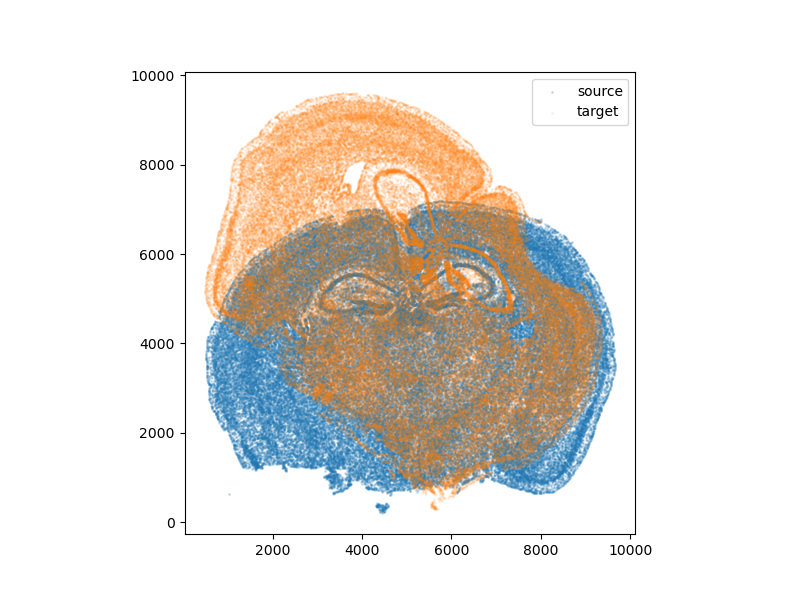

In [8]:
fig, ax = plt.subplots()
ax.scatter(xI, yI, s=1, alpha=0.2, label='source')
ax.scatter(xJ, yJ, s=1, alpha=0.1, label='target')
#ax.set_xlim(min(xI.min(), xJ.min()), max(xI.max(), xJ.max()))
#ax.set_ylim(min(yI.min(), yJ.min()), max(yI.max(), yJ.max()))
ax.set_aspect('equal')
ax.legend()
plt.show()

In [9]:
XI, YI, I, fig = STalign.rasterize(xI, yI, dx=15, blur=1.5, expand=1.2, draw=10000, wavelet_magnitude=False,use_windowing=True)

0 of 85958
10000 of 85958
20000 of 85958
30000 of 85958
40000 of 85958
50000 of 85958
60000 of 85958
70000 of 85958
80000 of 85958
85957 of 85958


In [11]:
XJ, YJ, J, fig = STalign.rasterize(xJ, yJ, dx=15, blur=1.5, expand=1.2, draw=10000, wavelet_magnitude=False,use_windowing=True)

0 of 84172
10000 of 84172
20000 of 84172
30000 of 84172
40000 of 84172
50000 of 84172
60000 of 84172
70000 of 84172
80000 of 84172
84171 of 84172


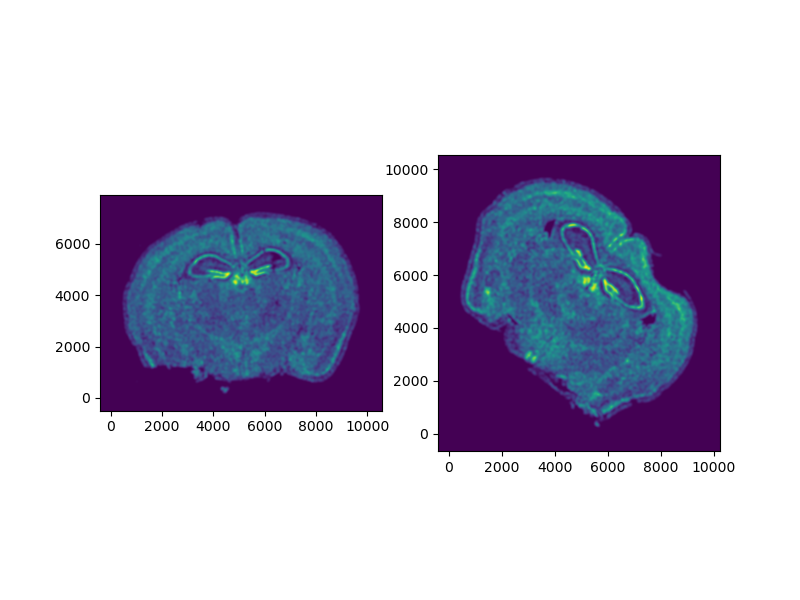

In [12]:
# get extent of images
extentI = STalign.extent_from_x((YI,XI))
extentJ = STalign.extent_from_x((YJ,XJ))

# plot rasterized images
fig,ax = plt.subplots(1,2)
ax[0].imshow(I[0], extent=extentI)
ax[1].imshow(J[0], extent=extentJ)
ax[0].invert_yaxis()
ax[1].invert_yaxis()

In [24]:
''' Tools for aligning spatial transcriptomics data
'''

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.nn.functional import grid_sample

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # for csv.
from matplotlib import cm
from matplotlib.lines import Line2D
import os
from os.path import exists,split,join,splitext
from os import makedirs
import glob
import requests
from collections import defaultdict
import nrrd
import torch
from torch.nn.functional import grid_sample
import tornado
import sys
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import copy
import pandas as pd

def normalize(arr, t_min=0, t_max=1):
    return norm_arr



def rasterize(x, y, g=np.ones(1), dx=30.0, blur=1.0, expand=1.1, draw=10000, wavelet_magnitude=False,use_windowing=True):
    return output
    

    
def rasterize_with_signal(x, y, s=None, dx=30.0, blur=1.0, expand=1.1, draw=0, wavelet_magnitude=False,use_windowing=True):
    return output
    
        


def rasterizePCA(x, y, G):
    return X, Y, W, V, Z, nrows, ncols



def make_scree(W, name, p=6):
    return fig



def saveRasters(X, Y, W, V, Z, scree_fig, nrows, ncols, name, path):
    print(f"Saved all {name} files!\n")
    
    

    
def interp(x,I,phii,**kwargs):
    return out[0]

# build an interp function from grid sample
def interp3D(x,I,phii,**kwargs):
    '''
    Interpolate the 3D image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (4D arrays with first channel storing component)    
    
    Parameters
    ----------
    x : list of arrays
        List of arrays storing the pixel locations along each image axis. convention is row column order not xy.
    I : array
        Image array. First axis should contain different channels.
    phii : array
        Sampling array. First axis should contain sample locations corresponding to each axis.
    **kwargs : dict
        Other arguments fed into the torch interpolation function torch.nn.grid_sample
        
    
    Returns
    -------
    out : torch tensor
            The image I resampled on the points defined in phii.
    
    Notes
    -----
    Convention is to use align_corners=True.
    
    This uses the torch library.
    '''
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(3):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done

    # NOTE I should check that I can reproduce identity
    # note that phii must now store x,y,z along last axis
    # is this the right order?
    # I need to put batch (none) along first axis
    # what order do the other 3 need to be in?    
    out = grid_sample(I[None],phii.flip(0).permute((1,2,3,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension

    return out[0]


def clip(I):
    ''' clip an arrays values between 0 and 1.  Useful for visualizing
    
    Parameters
    ----------
    I : torch tensor
        A torch tensor to clip.
    
    Returns
    -------
    Ic : torch tensor
        Clipped torch tensor.
    
    '''
    Ic = torch.clone(I)
    Ic[Ic<0]=0
    Ic[Ic>1]=1
    return Ic



# timesteps will be along the first axis
def v_to_phii(xv,v):
    ''' Integrate a velocity field over time to return a position field (diffeomorphism).
    
    Parameters
    ----------
    xv : list of torch tensor 
        List of 1D tensors describing locations of sample points in v
    v : torch tensor
        5D (nt,2,v0,v1) velocity field
    
    Returns
    -------
    phii: torch tensor
        Inverse map (position field) computed by method of characteristics

    '''
    
    XV = torch.stack(torch.meshgrid(xv))
    phii = torch.clone(XV)
    dt = 1.0/v.shape[0]
    for t in range(v.shape[0]):
        Xs = XV - v[t]*dt
        phii = interp(xv,phii-XV,Xs)+Xs
    return phii

def v_to_phii_3D(xv,v):
    ''' Integrate a 3D velocity field over time to return a 3D position field (diffeomorphism).
    
    Parameters
    ----------
    xv : list of torch tensor 
        List of 1D tensors describing locations of sample points in v
    v : torch tensor
        5D (nt,3,v0,v1,v2) velocity field
    
    Returns
    -------
    phii: torch tensor
        Inverse map (position field) computed by method of characteristics

    '''
    
    XV = torch.stack(torch.meshgrid(xv))
    phii = torch.clone(XV)
    dt = 1.0/v.shape[0]
    for t in range(v.shape[0]):
        Xs = XV - v[t]*dt
        phii = interp3D(xv,phii-XV,Xs)+Xs
    return phii

def to_A(L,T):
    ''' Convert a linear transform matrix and a translation vector into an affine matrix.
    
    Parameters
    ----------
    L : torch tensor
        2x2 linear transform matrix
        
    T : torch tensor
        2 element translation vector (note NOT 2x1)
        
    Returns
    -------
    
    A : torch tensor
        Affine transform matrix
        
        
    '''
    O = torch.tensor([0.,0.,1.],device=L.device,dtype=L.dtype)
    A = torch.cat((torch.cat((L,T[:,None]),1),O[None]))
    return A
def to_A_3D(L,T):
    ''' Convert a linear transform matrix and a translation vector into an affine matrix.
    
    Parameters
    ----------
    L : torch tensor
        3x3 linear transform matrix
        
    T : torch tensor
        3 element translation vector (note NOT 2x1)
        
    Returns
    -------
    
    A : torch tensor
        Affine transform matrix
        
        
    '''
    O = torch.tensor([0.,0.,0.0,1.],device=L.device,dtype=L.dtype)
    A = torch.cat((torch.cat((L,T[:,None]),1),O[None]))
    return A

def extent_from_x(xJ):
    ''' Given a set of pixel locations, returns an extent 4-tuple for use with np.imshow.
    
    Note inputs are locations of pixels along each axis, i.e. row column not xy.
    
    Parameters
    ----------
    xJ : list of torch tensors
        Location of pixels along each axis
    
    Returns
    -------
    extent : tuple
        (xmin, xmax, ymin, ymax) tuple
    
    Examples
    --------
    
    >>> extent_from_x(xJ)
    >>> fig,ax = plt.subplots()
    >>> ax.imshow(J,extent=extentJ)
    
    '''
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = ( (xJ[1][0] - dJ[1]/2.0).item(),
               (xJ[1][-1] + dJ[1]/2.0).item(),
               (xJ[0][-1] + dJ[0]/2.0).item(),
               (xJ[0][0] - dJ[0]/2.0).item())
    return extentJ

def L_T_from_points(pointsI,pointsJ):
    '''
    Compute an affine transformation from points.
    
    Note for an affine transformation (6dof) we need 3 points.
    
    Outputs, L,T should be rconstructed blockwize like [L,T;0,0,1]
    
    Parameters
    ----------
    pointsI : array
        An Nx2 array of floating point numbers describing source points in ROW COL order (not xy)
    pointsJ : array
        An Nx2 array of floating point numbers describing target points in ROW COL order (not xy)
    
    Returns
    -------
    L : array
        A 2x2 linear transform array.
    T : array
        A 2 element translation vector
    '''
    if pointsI is None or pointsJ is None:
        raise Exception('Points are set to None')
        
    nI = pointsI.shape[0]
    nJ = pointsJ.shape[0]
    if nI != nJ:
        raise Exception(f'Number of pointsI ({nI}) is not equal to number of pointsJ ({nJ})')
    if pointsI.shape[1] != 2:
        raise Exception(f'Number of components of pointsI ({pointsI.shape[1]}) should be 2')
    if pointsJ.shape[1] != 2:
        raise Exception(f'Number of components of pointsJ ({pointsJ.shape[1]}) should be 2')
    # transformation model
    if nI < 3:
        # translation only 
        L = np.eye(2)
        T = np.mean(pointsJ,0) - np.mean(pointsI,0)
    else:
        # we need an affine transform
        pointsI_ = np.concatenate((pointsI,np.ones((nI,1))),1)
        pointsJ_ = np.concatenate((pointsJ,np.ones((nI,1))),1)
        II = pointsI_.T@pointsI_
        IJ = pointsI_.T@pointsJ_
        A = (np.linalg.inv(II)@IJ).T        
        L = A[:2,:2]
        T = A[:2,-1]
    return L,T


def LDDMM(xI,I,xJ,J,pointsI=None,pointsJ=None,
          L=None,T=None,A=None,v=None,xv=None,
          a=500.0,p=2.0,expand=2.0,nt=3,
         niter=5000,diffeo_start=0, epL=2e-8, epT=2e-1, epV=2e3,
         sigmaM=1.0,sigmaB=2.0,sigmaA=5.0,sigmaR=5e5,sigmaP=2e1,
          device='cpu',dtype=torch.float64, muB=None, muA=None):
    ''' Run LDDMM between a pair of images.
    
    This jointly estimates an affine transform A, and a diffeomorphism phi.
    The map is off the form x -> A phi x
    
    
    Parameters
    ----------
    xI : list of torch tensor
        Location of voxels in source image I
    I : torch tensor
        source image I, with channels along first axis        
    xJ : list of torch tensor
        Location of voxels in target image J
    J : torch tensor
        Target image J, with channels along first axis
    L : torch tensor
        Initial guess for linear transform (2x2 torch tensor). Defaults to None (identity).
    T : torch tensor
        Initial guess for translation (2 element torch tensor). Defaults to None (identity)
    A : torch tensor
        Initial guess for affine matrix.  Either L and T can be specified, or A, but not both.
        Defaults to None (identity).
    v : torch tensor
        Initial guess for velocity field
    xv : torch tensor
        pixel locations for velocity field
    a : float
        Smoothness scale of velocity field (default 500.0)
    p : float
        Power of Laplacian in velocity regularization (default 2.0)
    expand : float
        Factor to expand size of velocity field around image boundaries (default 2.0)
    nt : int
        Number of timesteps for integrating velocity field (default 3). Ignored if you input v.
    pointsI : torch tensor
        N x 2 set of corresponding points for matching in source image. Default None (no points).
    pointsJ : torch tensor
        N x 2 set of corresponding points for matching in target image. Default None (no points).
    niter : int
        Number of iterations of gradient descent optimization
    diffeo_start : int
        Number of iterations of gradient descent optimization for affine only, before nonlinear deformation.
    epL : float
        Gradient descent step size for linear part of affine.
    epT : float
        Gradient descent step size of translation part of affine.
    epV : float
        Gradient descent step size for velocity field.
    sigmaM : float
        Standard deviation of image matching term for Gaussian mixture modeling in cost function. 
        This term generally controls matching accuracy with smaller corresponding to more accurate.
        As an common example (rule of thumb), you could chose this parameter to be the variance of the pixels
        in your target image.
    sigmaB : float
        Standard deviation of backtround term for Gaussian mixture modeling in cost function. 
        If there is missing tissue in target, we may label some pixels in target as background,
        and not enforce matching here.
    sigmaA : float
        Standard deviation of artifact term for Gaussian mixture modeling in cost function. 
        If there are artifacts in target or other lack of corresponding between template and target, 
        we may label some pixels in target as artifact, and not enforce matching here.
    sigmaR: float
        Standard deviation for regularization. Smaller sigmaR means a smoother resulting transformation. 
        Regularization is of the form: 0.5/sigmaR^2 int_0^1 int_X |Lv|^2 dx dt. 
    sigmaP: float
        Standard deviation for matching of points.  
        Cost is of the form 0.5/sigmaP^2 sum_i (source_point_i - target_point_i)^2
    device: str
        torch device. defaults to 'cpu'. Can also be 'cuda:0' for example.
    dtype: torch dtype
        torch data type. defaults to torch.float64
    muA: torch tensor whose dimension is the same as the target image
        Defaults to None, which means we estimate this. If you provide a value, we will not estimate it.
        If the target is a RGB image, this should be a tensor of size 3.
        If the target is a grayscale image, this should be a tensor of size 1.
    muB: torch tensor whose dimension is the same as the target image
        Defaults to None, which means we estimate this. If you provide a value, we will not estimate it.
        
    Returns a dictionary
    -------
    {
    'A': torch tensor
        Affine transform
    'v': torch tensor
        Velocity field
    'xv': list of torch tensor
        Pixel locations in v
    'WM': torch tensor
        Resulting weight 2D array (matching)
    'WB': torch tensor
        Resulting weight 2D array (background)
    'WA': torch tensor
        Resulting weight 2D array (artifact)
    }
    
    '''
    
    
    
    
    # todo
    # implement local?
    # more iters

    #niter = 2000
    #diffeo_start = 100
    #epL = 5e-11
    #epT = 5e-4
    #epV = 5e1
    #niter = 5000

    # check initial inputs
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:2,:2],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:2,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    
    #L = torch.eye(2,device=device,dtype=dtype,requires_grad=True)
    ##L.data[0,0] = -1.0
    ##L.data[:2,:2] *= 0.2
    #T = torch.zeros(2,device=device,dtype=dtype,requires_grad=True)
    ##T.data[0] = +2000.0
    ##T.data[1] = -xI[1][-1]/2.0*1.1

    # velocity
    #a = 500.0
    #p = 3.0
    #expand = 2.0
    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)]
        XV = torch.stack(torch.meshgrid(xv),-1)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2]),device=device,dtype=dtype,requires_grad=True)
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = extent_from_x(xv)
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype)
    
    
 
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
    extentF = extent_from_x(fv)
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki.clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()


    # nt = 3
    


    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1
    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2),device=J.device,dtype=J.dtype)
        pointsJ = torch.zeros((0,2),device=J.device,dtype=J.dtype) 
    elif (pointsI is None and pointsJ is not None) or (pointsJ is None and pointsI is not None):
        raise Exception('Must specify corresponding sets of points or none at all')
    else:
        pointsI = torch.tensor(pointsI,device=J.device,dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ,device=J.device,dtype=J.dtype)
    
    
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = (xJ[1][0].item()-dJ[1].item()/2.0,
          xJ[1][-1].item()+dJ[1].item()/2.0,
          xJ[0][-1].item()+dJ[0].item()/2.0,
          xJ[0][0].item()-dJ[0].item()/2.0)
    
    #sigmaM = 0.2
    #sigmaB = 0.19
    #sigmaA = 0.3
    #sigmaR = 5e5
    #sigmaP = 2e-1
    
    if muA is None:
        estimate_muA = True
    else:
        estimate_muA = False
    if muB is None:
        estimate_muB = True
    else:
        estimate_muB = False
    
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    figE,axE = plt.subplots(1,3)
    Esave = []

    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass
    for it in range(niter):
        # make A
        A = to_A(L,T)
        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points
        Xs = (Ai[:2,:2]@XJ[...,None])[...,0] + Ai[:2,-1]    
        # now diffeo, not semilagrange here
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
        # and points
        pointsIt = torch.clone(pointsI)
        if pointsIt.shape[0] >0:
            for t in range(nt):            
                pointsIt += interp(xv,v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
            pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T

        # transform image
        AI = interp(xI,I,Xs.permute(2,0,1),padding_mode="border")

        # transform the contrast
        B = torch.ones(1+AI.shape[0],AI.shape[1]*AI.shape[2],device=AI.device,dtype=AI.dtype)
        B[1:AI.shape[0]+1] = AI.reshape(AI.shape[0],-1)
        #B = torch.ones(10,AI.shape[1]*AI.shape[2],device=AI.device,dtype=AI.dtype)
        #B[1:4] = AI.reshape(AI.shape[0],-1)
        #B[4] = (AI[0][None]**2).reshape(1,-1)
        #B[5] = (AI[1][None]**2).reshape(1,-1)
        #B[6] = (AI[2][None]**2).reshape(1,-1)
        #B[7] = (AI[0][None]*AI[1][None]).reshape(1,-1)
        #B[8] = (AI[0][None]*AI[2][None]).reshape(1,-1)
        #B[9] = (AI[1][None]*AI[2][None]).reshape(1,-1)
        with torch.no_grad():    
            BB = B@(B*WM.ravel()).T
            BJ = B@((J*WM).reshape(J.shape[0],J.shape[1]*J.shape[2])).T
            small = 0.1
            coeffs = torch.linalg.solve(BB + small*torch.eye(BB.shape[0],device=BB.device,dtype=BB.dtype),BJ)
        fAI = ((B.T@coeffs).T).reshape(J.shape)

        # objective function
        EM = torch.sum((fAI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EM + ER
        tosave = [E.item(), EM.item(), ER.item()]
        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())
        
        Esave.append( tosave )
        # gradient update
        E.backward()
        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            L.grad.zero_()
            T.grad.zero_()
            

            # v grad
            vgrad = v.grad
            # smooth it
            vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2))*K[...,None],dim=(1,2)).real
            if it >= diffeo_start:
                v -= vgrad*epV
            v.grad.zero_()


        # update weights
        if not it%5:
            with torch.no_grad():
                # M step for these params
                if estimate_muA:
                    muA = torch.sum(WA*J,dim=(-1,-2))/torch.sum(WA)
                if estimate_muB:
                    muB = torch.sum(WB*J,dim=(-1,-2))/torch.sum(WB)
                #if it <= 200:
                #    muA = torch.tensor([0.75,0.77,0.79],device=J.device,dtype=J.dtype)
                #    muB = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.96

                if it >= 50:

                    W = torch.stack((WM,WA,WB))
                    pi = torch.sum(W,dim=(1,2))
                    pi += torch.max(pi)*1e-6
                    pi /= torch.sum(pi)


                    # now the E step, update the weights
                    WM = pi[0]* torch.exp( -torch.sum((fAI - J)**2,0)/2.0/sigmaM**2 )/np.sqrt(2.0*np.pi*sigmaM**2)**J.shape[0]
                    WA = pi[1]* torch.exp( -torch.sum((muA[...,None,None] - J)**2,0)/2.0/sigmaA**2 )/np.sqrt(2.0*np.pi*sigmaA**2)**J.shape[0]
                    WB = pi[2]* torch.exp( -torch.sum((muB[...,None,None] - J)**2,0)/2.0/sigmaB**2 )/np.sqrt(2.0*np.pi*sigmaB**2)**J.shape[0]
                    WS = WM+WB+WA
                    WS += torch.max(WS)*1e-6
                    WM /= WS
                    WB /= WS
                    WA /= WS




        # draw
        if not it%10:
            ax[0].cla()
            ax[0].imshow(   ((AI-torch.amin(AI,(1,2))[...,None,None])/(torch.amax(AI,(1,2))-torch.amin(AI,(1,2)))[...,None,None]).permute(1,2,0).clone().detach().cpu(),extent=extentJ)
            ax[0].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[0].set_title('space tformed source')
            
            ax[1].cla()    
            ax[1].imshow(clip(fAI.permute(1,2,0).clone().detach()/torch.max(J).item()).cpu(),extent=extentJ)
            ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[1].set_title('contrast tformed source')
            
            ax[5].cla()
            ax[5].imshow(clip( (fAI - J)/(torch.max(J).item())*3.0  ).permute(1,2,0).clone().detach().cpu()*0.5+0.5,extent=extentJ)
            ax[5].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[5].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[5].set_title('Error')

            ax[2].cla()
            ax[2].imshow(J.permute(1,2,0).cpu()/torch.max(J).item(),extent=extentJ)
            ax[2].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[2].set_title('Target')

            ax[4].cla()
            ax[4].imshow(clip(torch.stack((WM,WA,WB),-1).clone().detach()).cpu(),extent=extentJ)
            ax[4].set_title('Weights')


            toshow = v[0].clone().detach().cpu()
            toshow /= torch.max(torch.abs(toshow))
            toshow = toshow*0.5+0.5
            toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
            ax[3].cla()
            ax[3].imshow(clip(toshow),extent=extentV)
            ax[3].set_title('velocity')
            
            axE[0].cla()
            axE[0].plot(Esave)
            axE[0].legend(['E','EM','ER','EP'])
            axE[0].set_yscale('log')
            axE[1].cla()
            axE[1].plot([e[:2] for e in Esave])
            axE[1].legend(['E','EM'])
            axE[1].set_yscale('log')
            axE[2].cla()
            axE[2].plot([e[2] for e in Esave])
            axE[2].legend(['ER'])
            axE[2].set_yscale('log')



            fig.canvas.draw()
            figE.canvas.draw()
            
    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach()
    }


def LDDMM_3D_to_slice(xI,I,xJ,J,pointsI=None,pointsJ=None,
        L=None,T=None,A=None,v=None,xv=None,
        a=500.0,p=2.0,expand=1.25,nt=3,
        niter=5000,diffeo_start=0, epL=1e-6, epT=1e1, epV=1e3,
        sigmaM=1.0,sigmaB=2.0,sigmaA=5.0,sigmaR=1e8,sigmaP=2e1,
        device='cpu',dtype=torch.float64, muA=None, muB = None):
    ''' LDDMM for 3D to 2D slice mapping.
    
    muA: torch tensor whose dimension is the same as the target image
        Defaults to None, which means we estimate this. If you provide a value, we will not estimate it.
        If the target is a RGB image, this should be a tensor of size 3.
        If the target is a grayscale image, this should be a tensor of size 1.
    muB: torch tensor whose dimension is the same as the target image
        Defaults to None, which means we estimate this. If you provide a value, we will not estimate it.
        

    '''
    if muA is None:
        estimate_muA = True
    else:
        estimate_muA = False
    if muB is None:
        estimate_muB = True
    else:
        estimate_muB = False
        
    # check initial inputs and convert to torch
    if A is not None:
        # if we specify an A
        if L is not None or T is not None:
            raise Exception('If specifying A, you must not specify L or T')
        L = torch.tensor(A[:3,:3],device=device,dtype=dtype,requires_grad=True)
        T = torch.tensor(A[:3,-1],device=device,dtype=dtype,requires_grad=True)   
    else:
        # if we do not specify A                
        if L is None: L = torch.eye(3,device=device,dtype=dtype,requires_grad=True)
        if T is None: T = torch.zeros(3,device=device,dtype=dtype,requires_grad=True)
    
    L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
    T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
    # change to torch
    I = torch.tensor(I,device=device,dtype=dtype)                         
    J = torch.tensor(J,device=device,dtype=dtype)
    if J.ndim == 3:
        J = J[:,None] # add a z slice dimension


    if v is not None and xv is not None:
        v = torch.tensor(v,device=device,dtype=dtype,requires_grad=True)
        xv = [torch.tensor(x,device=device,dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv),-1)
        nt = v.shape[0]        
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI],device=device,dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI],device=device,dtype=dtype)
        minv,maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0],device=device,dtype=dtype)[...,None]*(maxv-minv)*expand
        xv = [torch.arange(m,M,a*0.5,device=device,dtype=dtype) for m,M in zip(minv,maxv)]
        XV = torch.stack(torch.meshgrid(xv),-1)
        v = torch.zeros((nt,XV.shape[0],XV.shape[1],XV.shape[2],XV.shape[3]),device=device,dtype=dtype,requires_grad=True)
        
    else:
        raise Exception(f'If inputting an initial v, must input both xv and v')
    extentV = extent_from_x(xv[1:])
    dv = torch.as_tensor([x[1]-x[0] for x in xv],device=device,dtype=dtype)
    
    
 
    fv = [torch.arange(n,device=device,dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
    extentF = extent_from_x(fv[1:])
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 + 2.0*a**2* torch.sum( (1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)

    K = 1.0/LL
    #fig,ax = plt.subplots()
    #ax.imshow(K,vmin=0.0,vmax=0.1,extent=extentF)
    
    #fig,ax = plt.subplots()
    #ax.imshow(K[0].cpu())
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real
    fig,ax = plt.subplots()
    ax.imshow(Ki[Ki.shape[0]//2].clone().detach().cpu().numpy(),vmin=0.0,extent=extentV)
    ax.set_title('smoothing kernel')
    fig.canvas.draw()

    # steps
    epL = torch.tensor(epL,device=device,dtype=dtype)
    epT = torch.tensor(epT,device=device,dtype=dtype)

    # initialize weights
    WM = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.5
    WB = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.4
    WA = torch.ones(J[0].shape,dtype=J.dtype,device=J.device)*0.1

    # locations of pixels
    extentI = extent_from_x(xI[1:]) 
    xI = [torch.tensor(x,device=device,dtype=dtype) for x in xI]
    if len(xJ) == 2:
        xJ = [[0.0],xJ[0],xJ[1]]    
    extentJ = extent_from_x(xJ[1:])
    xJ = [torch.tensor(x,device=device,dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI,indexing='ij'),-1)
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    dJ = [x[1]-x[0] for x in xJ[1:]]
    
    # metric TODO
    '''
    g = torch.zeros((12,12))
    count = 0
    for i in range(12):
        Ei = (torch.arange(16)==i).reshape((4,4))*1.0
        EiXI = (Ei[:3,:3]@XI[...,None])[...,0] + Ei[:3,-1]
        for j in range(12):
            Ej = (torch.arange(16)==j).reshape((4,4))*1.0
            EjXI = (Ej[:3,:3]@XI[...,None])[...,0] + Ej[:3,-1]
            g[i,j] = torch.mean(torch.sum(EiXI*EjXI,-1))

    gi = torch.inverse(g)
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(g)
    ax[0].set_title('Metric') 
    ax[1].imshow(gi)    
    ax[1].set_title('Inverse metric') 
    fig.canvas.draw()
    '''

    # a figure
    fig,ax = plt.subplots(2,3)
    ax = ax.ravel()
    figE,axE = plt.subplots(1,3)
    axE = axE.ravel()
    Esave = []
    # zero gradients
    try:
        L.grad.zero_()
    except:
        pass
    try:
        T.grad.zero_()
    except:
        pass


    for it in range(niter):
        # make A
        A = to_A_3D(L,T)
        # Ai
        Ai = torch.linalg.inv(A)
        # transform sample points        
        Xs = (Ai[:-1,:-1]@XJ[...,None])[...,0] + Ai[:-1,-1]

        # now diffeo, not semilagrange here

        for t in range(nt-1,-1,-1):
            Xs = Xs + interp3D(xv,-v[t].permute(3,0,1,2),Xs.permute(3,0,1,2)).permute(1,2,3,0)/nt
        # # and points (not in 3D)        
        # pointsIt = torch.clone(pointsI)
        # if pointsIt.shape[0] >0:
        #     for t in range(nt):            
        #         pointsIt += interp(xv,v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
        #     pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T
        
        # transform image
        AI = interp3D(xI,I,Xs.permute(3,0,1,2),padding_mode="border")
        

        # transform the contrast
        B = torch.ones(1+AI.shape[0],AI.shape[1]*AI.shape[2]*AI.shape[3],device=AI.device,dtype=AI.dtype)
        B[1:AI.shape[0]+1] = AI.reshape(AI.shape[0],-1)
        #B = torch.ones(10,AI.shape[1]*AI.shape[2],device=AI.device,dtype=AI.dtype)
        #B[1:4] = AI.reshape(AI.shape[0],-1)
        #B[4] = (AI[0][None]**2).reshape(1,-1)
        #B[5] = (AI[1][None]**2).reshape(1,-1)
        #B[6] = (AI[2][None]**2).reshape(1,-1)
        #B[7] = (AI[0][None]*AI[1][None]).reshape(1,-1)
        #B[8] = (AI[0][None]*AI[2][None]).reshape(1,-1)
        #B[9] = (AI[1][None]*AI[2][None]).reshape(1,-1)
        with torch.no_grad():    
            BB = B@(B*WM.ravel()).T
            BJ = B@((J*WM).reshape(J.shape[0],J.shape[1]*J.shape[2]*J.shape[3])).T
            small = 0.1
            coeffs = torch.linalg.solve(BB + small*torch.eye(BB.shape[0],device=BB.device,dtype=BB.dtype),BJ)
        fAI = ((B.T@coeffs).T).reshape(J.shape)

        # objective function
        EM = torch.sum((fAI - J)**2*WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EM + ER
        tosave = [E.item(), EM.item(), ER.item()]
        #if pointsIt.shape[0]>0:
        #    EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
        #    E += EP
        #    tosave.append(EP.item())
        
        Esave.append( tosave )
        # gradient update
        E.backward()
        with torch.no_grad():            
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad

            L.grad.zero_()
            T.grad.zero_()
            

            # v grad
            vgrad = v.grad
            # smooth it            
            if it >= diffeo_start:
                vgrad = torch.fft.ifftn(torch.fft.fftn(vgrad,dim=(1,2,3))*K[...,None],dim=(1,2,3)).real
                v -= vgrad*epV
            v.grad.zero_()


        # update weights
        if not it%5:
            with torch.no_grad():
                # M step for these params
                if estimate_muA:
                    muA = torch.sum(WA*J,dim=(-1,-2,-3))/torch.sum(WA)
                if estimate_muB:
                    muB = torch.sum(WB*J,dim=(-1,-2,-3))/torch.sum(WB)
                #if it <= 200:
                #    muA = torch.tensor([0.75,0.77,0.79],device=J.device,dtype=J.dtype)
                #    muB = torch.ones(J.shape[0],device=J.device,dtype=J.dtype)*0.96

                if it >= 50:

                    W = torch.stack((WM,WA,WB))
                    pi = torch.sum(W,dim=(1,2,3))
                    pi += torch.max(pi)*1e-6
                    pi /= torch.sum(pi)


                    # now the E step, update the weights
                    WM = pi[0]* torch.exp( -torch.sum((fAI - J)**2,0)/2.0/sigmaM**2 )/np.sqrt(2.0*np.pi*sigmaM**2)**J.shape[0]
                    WA = pi[1]* torch.exp( -torch.sum((muA[...,None,None,None] - J)**2,0)/2.0/sigmaA**2 )/np.sqrt(2.0*np.pi*sigmaA**2)**J.shape[0]
                    WB = pi[2]* torch.exp( -torch.sum((muB[...,None,None,None] - J)**2,0)/2.0/sigmaB**2 )/np.sqrt(2.0*np.pi*sigmaB**2)**J.shape[0]
                    WS = WM+WB+WA
                    WS += torch.max(WS)*1e-6
                    WM /= WS
                    WB /= WS
                    WA /= WS




        # draw
        if not it%10:
            ax[0].cla()
            Ishow = ((AI-torch.amin(AI,(1,2,3))[...,None,None])/(torch.amax(AI,(1,2,3))-torch.amin(AI,(1,2,3)))[...,None,None,None]).permute(1,2,3,0).clone().detach().cpu()
            ax[0].imshow(  Ishow[0,...,0] ,extent=extentJ)
            #ax[0].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[0].set_title('space tformed source')

            ax[1].cla()    
            Ishow = clip(fAI.permute(1,2,3,0).clone().detach()/torch.max(J).item()).cpu()
            ax[1].imshow(Ishow[0,...,0],extent=extentJ,vmin=0,vmax=1)
            #ax[1].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            ax[1].set_title('contrast tformed source')
            
            ax[5].cla()
            Ishow = clip( (fAI - J)/(torch.max(J).item())*3.0  ).permute(1,2,3,0).clone().detach().cpu()*0.5+0.5
            ax[5].imshow(Ishow[0,...,0],extent=extentJ)
            #ax[5].scatter(pointsIt[:,1].clone().detach().cpu(),pointsIt[:,0].clone().detach().cpu())
            #ax[5].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[5].set_title('Error')

            ax[2].cla()
            Ishow = J.permute(1,2,3,0).cpu()/torch.max(J).item()
            ax[2].imshow(Ishow[0,...,0],extent=extentJ,vmin=0,vmax=1)
            #ax[2].scatter(pointsJ[:,1].clone().detach().cpu(),pointsJ[:,0].clone().detach().cpu())
            ax[2].set_title('Target')

            ax[4].cla()
            ax[4].imshow(clip(torch.stack((WM,WA,WB),-1).clone().detach()).cpu()[0],extent=extentJ)
            ax[4].set_title('Weights')


            toshow = v[0].clone().detach().cpu() # initial velocity, components are rgb
            toshow /= torch.max(torch.abs(toshow))
            toshow = toshow*0.5+0.5
            #toshow = torch.cat((toshow,torch.zeros_like(toshow[...,0][...,None])),-1)   
            ax[3].cla()
            ax[3].imshow(clip(toshow)[toshow.shape[0]//2],extent=extentV)
            ax[3].set_title('velocity')
            
            axE[0].cla()

            # Detect which energy components are present based on the first Esave entry length
            has_gene = (Ig is not None and Jg is not None)
            labels = ['EM', 'ER', 'EP']
            
            # Convert Esave to array for consistent indexing
            Earray = np.array(Esave, dtype=object)
            
            # Plot each energy component if available
            for i, lbl in enumerate(labels):
                if Earray.shape[1] > i:
                    axE[0].plot([e[i] for e in Esave], label=lbl)
            
            # Compute and plot total energy
            E_total = [np.sum(e) for e in Esave]
            axE[0].plot(E_total, 'k--', label='E_total', linewidth=1.5)
            
            # Add log scaling and legend
            axE[0].set_yscale('log')
            axE[0].legend()
            axE[0].set_title('Energy (components + total)')
            
            # Annotate total ΔE
            if len(E_total) > 1:
                deltaE = E_total[0] - E_total[-1]
                axE[0].text(
                    0.02, 0.95, f'Total ΔE: {deltaE:.2e}', transform=axE[0].transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
                )


            fig.canvas.draw()
            figE.canvas.draw()
            
    return {
        'A': A.clone().detach(), 
        'v': v.clone().detach(), 
        'xv': xv, 
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        'Xs': Xs.clone().detach()
    }



def build_transform(xv,v,A,direction='b',XJ=None):
    ''' Create sample points to transform source to target from affine and velocity.
    
    Parameters
    ----------
    xv : list of array
        Sample points for velocity
    v : array
        time dependent velocity field
    A : array
        Affine transformation matrix
    direction : char
        'f' for forward and 'b' for backward. 'b' is default and is used for transforming images.
        'f' is used for transforming points.
    XJ : array
        Sample points for target (meshgrid with ij index style).  Defaults to None 
        to keep sampling on the xv.
    
    Returns
    -------
    Xs : array
        Sample points in mehsgrid format.
    
    
    '''
    
    A = torch.tensor(A)
    if v is not None: v = torch.tensor(v) 
    if XJ is not None:
        # check some types here
        if isinstance(XJ,list):
            if XJ[0].ndim == 1: # need meshgrid
                XJ = torch.stack(torch.meshgrid([torch.tensor(x) for x in XJ],indexing='ij'),-1)
            elif XJ[0].ndim == 2: # assume already meshgrid
                XJ = torch.stack([torch.tensor(x) for x in XJ],-1)
            else:
                raise Exception('Could not understand variable XJ type')
            
        # if it is already in meshgrid form we just need to make sure it is a tensor
        XJ = torch.tensor(XJ)
    else:
        XJ = torch.stack(torch.meshgrid([torch.tensor(x) for x in xv],indexing='ij'),-1)
        
    if direction == 'b':
        Ai = torch.linalg.inv(A)
        # transform sample points
        Xs = (Ai[:-1,:-1]@XJ[...,None])[...,0] + Ai[:-1,-1]    
        # now diffeo, not semilagrange here
        if v is not None:
            nt = v.shape[0]
            for t in range(nt-1,-1,-1):
                Xs = Xs + interp(xv,-v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
    elif direction == 'f':
        Xs = torch.clone(XJ)
        if v is not None:
            nt = v.shape[0]
            for t in range(nt):
                Xs = Xs + interp(xv,v[t].permute(2,0,1),Xs.permute(2,0,1)).permute(1,2,0)/nt
        Xs = (A[:2,:2]@Xs[...,None])[...,0] + A[:2,-1]    
            
    else:
        raise Exception(f'Direction must be "f" or "b" but you input {direction}')
    return Xs 

def build_transform3D(xv,v,A,direction='b',XJ=None):
    ''' Create sample points to transform source to target from affine and velocity.
    
    Parameters
    ----------
    xv : list of array
        Sample points for velocity
    v : array
        time dependent velocity field
    A : array
        Affine transformation matrix
    direction : char
        'f' for forward and 'b' for backward. 'b' is default and is used for transforming images.
        'f' is used for transforming points.
    XJ : array
        Sample points for target (meshgrid with ij index style).  Defaults to None 
        to keep sampling on the xv.
    
    Returns
    -------
    Xs : array
        Sample points in mehsgrid format.
    
 
    
    '''
    
    A = torch.tensor(A)
    v = torch.tensor(v)
    if XJ is not None:
        # check some types here
        if isinstance(XJ,list):
            if XJ[0].ndim == 1: # need meshgrid
                XJ = torch.stack(torch.meshgrid([torch.tensor(x) for x in XJ],indexing='ij'),-1)
            elif XJ[0].ndim == 3: # assume already meshgrid
                XJ = torch.stack([torch.tensor(x) for x in XJ],-1)
            else:
                raise Exception('Could not understand variable XJ type')
            
        # if it is already in meshgrid form we just need to make sure it is a tensor
        XJ = torch.tensor(XJ)
    else:
        XJ = torch.stack(torch.meshgrid([torch.tensor(x) for x in xv],indexing='ij'),-1)
        
    if direction == 'b':
        Ai = torch.linalg.inv(A)
        # transform sample points
        Xs = (Ai[:-1,:-1]@XJ[...,None])[...,0] + Ai[:-1,-1]    
        # now diffeo, not semilagrange here
        nt = v.shape[0]
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp3D(xv,-v[t].permute(3,0,1,2),Xs.permute(3,0,1,2)).permute(1,2,3,0)/nt
    elif direction == 'f':
        Xs = torch.clone(XJ)
        nt = v.shape[0]
        for t in range(nt):
            Xs = Xs + interp(xv,v[t].permute(3,0,1,2),Xs.permute(3,0,1,2)).permute(1,2,0)/nt
        Xs = (A[:-1,:-1]@Xs[...,None])[...,0] + A[:-1,-1]    
            
    else:
        raise Exception(f'Direction must be "f" or "b" but you input {direction}')
    return Xs 

def transform_image_source_with_A(A, XI, I, XJ):
    '''
    Transform an image with an affine matrix
    
    Parameters
    ----------
    
    A  : torch tensor
         Affine transform matrix
        
    XI : list of numpy arrays
         List of arrays storing the pixel location in image I along each image axis. 
         convention is row column order not xy. i.e, 
         locations of pixels along the y axis (rows) followed by
         locations of pixels along the x axis (columns)  
    
    I  : numpy array
         A rasterized image with len(blur) channels along the first axis
        
    XJ : list of numpy arrays
         List of arrays storing the pixel location in image I along each image axis. 
         convention is row column order not xy. i.e, 
         locations of pixels along the y axis (rows) followed by
         locations of pixels along the x axis (columns)         
    
    Returns
    -------
    AI : torch tensor
        image I after affine transformation A, with channels along first axis
              
    '''
    xv = None
    v = None
    AI= transform_image_source_to_target(xv, v, A, XI, I, XJ=XJ)
    return AI

def transform_image_source_to_target(xv,v,A,xI,I,XJ=None):
    '''
    Transform an image
    '''
    phii = build_transform(xv,v,A,direction='b',XJ=XJ)    
    phiI = interp(xI,I,phii.permute(2,0,1),padding_mode="border")
    return phiI
    
    
def transform_image_target_to_source(xv,v,A,xJ,J,XI=None):
    '''
    Transform an image
    '''
    phi = build_transform(xv,v,A,direction='f',XJ=XI)    
    phiiJ = interp(xJ,J,phi.permute(2,0,1),padding_mode="border")
    return phiiJ
    
def transform_points_source_to_target(xv,v,A,pointsI):
    '''
    Transform points.  Note points are in row column order, not xy.
    '''
    #phi = build_transform(xv,v,A,direction='f',XJ=XI)
    if isinstance(pointsI,torch.Tensor):
        pointsIt = torch.clone(pointsI)
    else:
        pointsIt = torch.tensor(pointsI)
    nt = v.shape[0]
    for t in range(nt):            
        pointsIt += interp(xv,v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
    pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T
    return pointsIt
def transform_points_target_to_source(xv,v,A,pointsI):
    '''
    Transform points.  Note points are in row column order, not xy.
    '''
    
    if isinstance(pointsI,torch.Tensor):
        pointsIt = torch.clone(pointsI)
    else:
        pointsIt = torch.tensor(pointsI)
    Ai = torch.linalg.inv(A)
    pointsIt = (Ai[:2,:2]@pointsIt.T + Ai[:2,-1][...,None]).T
    nt = v.shape[0]
    for t in range(nt):            
        pointsIt += interp(xv,-v[t].permute(2,0,1),pointsIt.T[...,None])[...,0].T/nt
    return pointsIt

#given two sets of points, caluclates the target registratoin error (TRE) and their mean/std
def calculate_tre(pointsI, pointsJ):
    TRE_i = np.sqrt(np.sum((pointsI - pointsJ)**2,axis=1))
    meanTRE = np.mean(TRE_i)
    stdTRE = np.std(TRE_i)
    return meanTRE, stdTRE


#Download and store ontology
def download_aba_ontology(url,file_name): 
	''' Create 3D altas ontology
	    
	    Parameters
	    ----------
	    url : Link to url contain atlas ontology
	    file_name : File name to save atlas ontology
	    
	    Returns
	    -------
	    ontology_name : File name to store ontologies
	    namesdict : Dictionary of all brain rgeion names
	'''
	    
   
	r = requests.get(url)
	print(r)
	with open(file_name,'w') as f:
        	f.write(r.text)
	ontology_name = file_name

	O = pd.read_csv(ontology_name)

	# store the ontology in a dictionary
	namesdict = defaultdict(lambda: 'unk')
	namesdict[0] = 'bg'

	# we need to add the structure names from the structure_id
	for i,n in zip(O['id'],O['acronym']):
        	namesdict[i] = n
	return ontology_name,namesdict

def download_aba_image_labels(imageurl, labelurl, imagefile, labelfile):
	''' Create 3D altas image and region annotations
		    
		    Parameters
		    ----------
		    imageurl : array
		    		Link containing atlas cell stained image.
		    labelurl : array
		    		Link containing atlas altas images for each voxel in imageurl.
		    imagefile : array
		    		File location to save imageurl information.
		    labelfile : array
		    		File location to save labelurl information.
		    
		    Returns
		    -------
		    imagefile : array
		    		File location to save imageurl information.
		    labelfile : array
		    		File location to save labelurl information.	    
		    
	'''
	url = imageurl
	r = requests.get(url, stream=True)
	with open(imagefile, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
	imagefile = imagefile

	url = labelurl#'http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/annotation_50.nrrd'
	r = requests.get(url, stream=True)
	with open(labelfile, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
	labelfile = labelfile
	return imagefile, labelfile

def analyze3Dalign(labelfile, xv,v,mat, xJ, dx, scale_x, scale_y, x, y, X_, Y_, namesdict, device='cpu'):
	''' Create dataframe with region annotations and 3D coordinates of target brain slice
		    
		    Parameters
		    ----------
		    labelfile : array
		    		File name of 3D atlas with region annotations.
		    xv : list of array
        		Sample points for velocity
    		    v : array
        		time dependent velocity field
    		    A : array
        		Affine transformation matrix
    		    direction : char
        		'f' for forward and 'b' for backward. 'b' is default and is used for transforming images.
        		'f' is used for transforming points.
    		    XJ : array
        		Sample points for target (meshgrid with ij index style).  Defaults to None 
       		to keep sampling on the xv.
    
		    dx : int
		    	Step of rasterized image.
		    scale_x : double
		    	Value that x positions of atlas were scaled by
		    scale_y : double
		    	Value that y positions of atlas were scaled by
		    x : array
		    	X positions of target brain slice
		    y : array
		    	Y positions of target brain slice
		    X_ : array
		    	-
		    Y_ : array
		    	-
		    namesdict : Dictionary
		    		Dictionary of brain regions corresponding to region numbers
		    
		    Returns
		    -------
		    df : Dataframe containing each cell in original target brain slice, region annotations and 3D coordinates in terms of the altas.
	'''
	# map the annotations
	#xS = [np.arange(n)*d - (n-1)*d/2.0 for n,d in zip(nxS,dxS)]
	vol,hdr = nrrd.read(labelfile)
	L = vol
	dxL = np.diag(hdr['space directions'])
	nL = L.shape
	xL = [np.arange(n)*d - (n-1)*d/2 for n,d in zip(nL,dxL)]

	# next we'll chose a set of points to sample on
	# if we wanted to use the same resolution as our rasterized image, we would do this
	res = np.array(dx)
	XJ = np.stack(np.meshgrid(np.zeros(1),xJ[0],xJ[1],indexing='ij'),-1)
	# if we want to use a different resolution
	res = 10.0
	XJ = np.stack(np.meshgrid(np.zeros(1), np.arange(xJ[0][0],xJ[0][-1],res), np.arange(xJ[1][0],xJ[1][-1],res), indexing='ij'),-1)


	tform = build_transform3D(xv,v,mat,direction='b',XJ=torch.tensor(XJ,device=mat.device))

	AphiL = interp3D(
        	xL, 
        	torch.tensor(L[None].astype(np.float64),dtype=torch.float64,device=tform.device),
        	tform.permute(-1,0,1,2),
        	mode='nearest',
	)[0,0].int()
	AphiL = AphiL.detach().cpu()

	# now look at the cells and assign
	q = np.stack((y,x))
	qi = np.round(((q - np.stack([xJ[0][0],xJ[1][0]])[...,None])/res)).astype(int)
	# by definition, no points should be out of bounds
	# but if I change resolutions, there may be points out of bounds
	df_ = pd.DataFrame()
	labels = AphiL[qi[0],qi[1]]
	col = ((x - X_[0])/dx).astype(int)
	row = ((y - Y_[0])/dx).astype(int)
	df_['coord0'] = tform[0,row,col,0].detach().cpu()
	df_['coord1'] = tform[0,row,col,1].detach().cpu()
	df_['coord2'] = tform[0,row,col,2].detach().cpu()
	df_['x'] = x
	df_['y'] = y
	df_['struct_id'] = labels
    
	all_names = [namesdict[i] for i in df_['struct_id']]
	df_['acronym'] = all_names  
    
	return df_ 

def plot_brain_regions(df):
	''' Plot all brain regions in target brain slice with different color.
		    
		    Parameters
		    ----------
		    df : DataFrame
		    	Dataframe containing each cell in original target brain slice, region annotations and 3D coordinates in terms of the altas.
		    
		    Returns
		    -------
		    None
		    
	'''
	#plot brain regions
	brain_regions = np.unique(df['acronym'])
	fig,ax = plt.subplots()
	for i in range(len(brain_regions)):
            region_df = df[df['acronym']==brain_regions[i]]

            ax.scatter(region_df['x'], region_df['y'], label = brain_regions[i],s= 0.1)   
            ax.legend()

def plot_subset_brain_regions(df, brain_regions):
	''' Plot subset of brain regions in target brain slice with different color.
		    
		    Parameters
		    ----------
		    df : DataFrame
		    	Dataframe containing each cell in original target brain slice, region annotations and 3D coordinates in terms of the altas.
		    brain_regions : array
		    		Subset of brain regions of interest (i.e. ['CA1', 'CP', 'DG-sg'])
		    
		    Returns
		    -------
		    None
		    
	'''
    	#plot brain regions
	brain_regions = brain_regions
	fig,ax = plt.subplots()
	ax.scatter(df['x'], df['y'],color = 'grey',s= 0.1)   
	for i in range(len(brain_regions)):
	    region_df = df[df['acronym']==brain_regions[i]]
	    ax.scatter(region_df['x'], region_df['y'], label = brain_regions[i],s= 0.1)   
	    ax.legend()

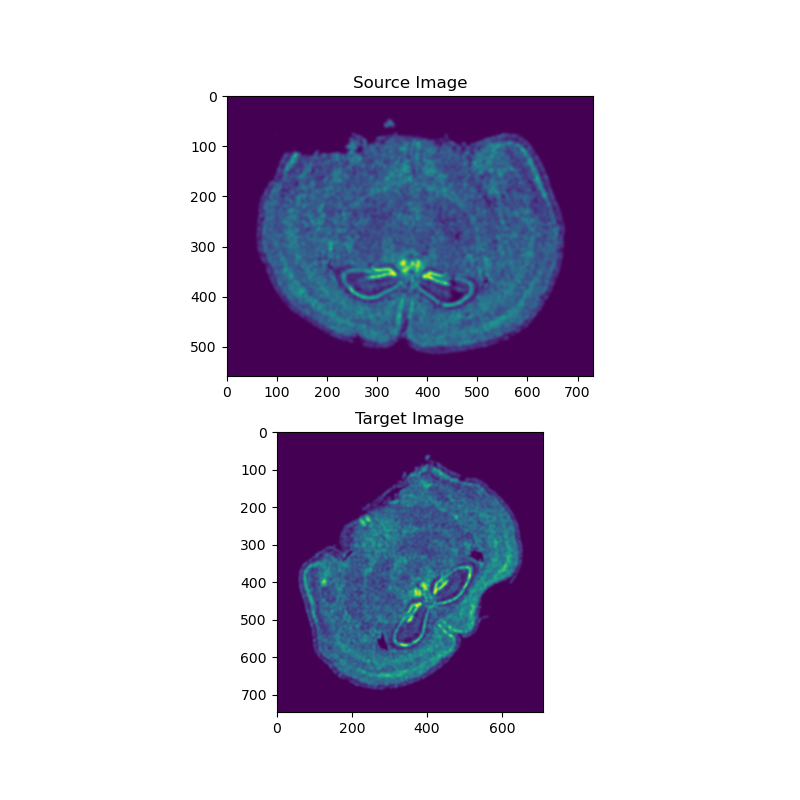

In [14]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, HBox, VBox, Label

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].set_title("Source Image")
ax[1].set_title("Target Image")

# Display images
im1_artist = ax[0].imshow(I[0])
im2_artist = ax[1].imshow(J[0])

# State dictionary
state = {
    'x1': None, 'y1': None,
    'x2': None, 'y2': None,
    'point': 0,
    'source_pts': [],
    'target_pts': []
}

# Label for instructions
label = Label(value="Click a landmark in the Source Image.")

# Click handler
def onclick(event):
    if event.inaxes == ax[0]:
        ix, iy = int(event.xdata), int(event.ydata)
        state['x1'], state['y1'] = ix, iy
        state['point'] = 1
        label.value = "Click the corresponding landmark in the Target Image."
        ax[0].scatter(ix, iy, c='r', s=30)
        fig.canvas.draw()
    elif event.inaxes == ax[1] and state['point'] == 1:
        ix, iy = int(event.xdata), int(event.ydata)
        state['x2'], state['y2'] = ix, iy
        state['point'] = 2
        label.value = "Press 'Record Landmark' to save this pair."
        ax[1].scatter(ix, iy, c='r', s=30)
        fig.canvas.draw()

# Record landmark button
def record_landmark(btn):
    if state['point'] == 2:
        state['source_pts'].append([state['x1'], state['y1']])
        state['target_pts'].append([state['x2'], state['y2']])
        state['point'] = 0
        label.value = "Click a landmark in the Source Image."
        print("Recorded points:")
        print("Source:", state['source_pts'])
        print("Target:", state['target_pts'])

# Done button
def done_selection(btn):
    label.value = f"Landmark selection finished. Total points: {len(state['source_pts'])}"
    print("Final Source Points:", state['source_pts'])
    print("Final Target Points:", state['target_pts'])
    fig.canvas.mpl_disconnect(cid)

# Create buttons
record_btn = Button(description="Record Landmark")
done_btn = Button(description="Done")
record_btn.on_click(record_landmark)
done_btn.on_click(done_selection)

# Connect click event
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Display buttons
display(VBox([label, HBox([record_btn, done_btn])]))

plt.show()

In [15]:
# use same source and target points from the one w gene exp
target_pts = [[66, 360],
  [375, 78],
  [530, 520],
  [130, 568],
  [527, 134],
  [367, 632],
  [618, 363]]
 
source_pts = [[129, 102],
  [577, 84],
  [387, 489],
  [70, 264],
  [650, 226],
  [215, 459],
  [541, 469]]

In [16]:
target_pts, source_pts

([[66, 360],
  [375, 78],
  [530, 520],
  [130, 568],
  [527, 134],
  [367, 632],
  [618, 363]],
 [[129, 102],
  [577, 84],
  [387, 489],
  [70, 264],
  [650, 226],
  [215, 459],
  [541, 469]])

In [17]:
pointsI = np.zeros([len(source_pts),2])
pointsJ = np.zeros([len(source_pts),2])

In [18]:
# np.max(np.array(source_pts)[:,0])-
pointsI[:,1] = np.array(XI[np.array(source_pts)[:,0]])
pointsI[:,0] = np.array(YI[np.array(source_pts)[:,1]])
pointsJ[:,1] = np.array(XJ[np.array(target_pts)[:,0]])
pointsJ[:,0] = np.array(YJ[np.array(target_pts)[:,1]])

In [19]:
L,T = STalign.L_T_from_points(pointsJ,pointsI)
A = STalign.to_A(torch.tensor(L),torch.tensor(T))

I = (I - np.min(I))/(np.max(I)-np.min(I))
J = (J - np.min(J))/(np.max(J)-np.min(J))

In [20]:
pointsI, pointsJ

(array([[1039.896541  , 1528.79585937],
        [ 769.896541  , 8248.79585937],
        [6844.896541  , 5398.79585937],
        [3469.896541  ,  643.79585937],
        [2899.896541  , 9343.79585937],
        [6394.896541  , 2818.79585937],
        [6544.896541  , 7708.79585937]]),
 array([[4755.28861376,  592.61398356],
        [ 525.28861376, 5227.61398356],
        [7155.28861376, 7552.61398356],
        [7875.28861376, 1552.61398356],
        [1365.28861376, 7507.61398356],
        [8835.28861376, 5107.61398356],
        [4800.28861376, 8872.61398356]]))

In [21]:
%%time
# run LDDMM
# specify device (default device for STalign.LDDMM is cpu)
if torch.cuda.is_available():
    device = 'cuda:0'
else:
    device = 'cpu'

# keep all other parameters default
params = {
            'niter': 1000,
            'a':500,
            'pointsI': pointsI,
            'pointsJ': pointsJ,
            'sigmaM': 0.25,
            'device':device,
            #'epV': 50
          }

out = LDDMM_orig([YI,XI],I,[YJ,XJ],J,**params)

/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_35067/445307987.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  L = torch.tensor(L,device=device,dtype=dtype,requires_grad=True)
/var/folders/jc/r13c712s6dj2g5bnkv832wk40000gn/T/ipykernel_35067/445307987.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T = torch.tensor(T,device=device,dtype=dtype,requires_grad=True)
/Users/iriskwon/miniforge3/envs/stalign-env/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3

CPU times: user 4min 26s, sys: 1min 58s, total: 6min 24s
Wall time: 3min 14s


In [22]:
A = out['A']
v = out['v']
xv = out['xv']

In [23]:
A

tensor([[ 1.0478e+00, -9.1134e-03,  6.3915e+01],
        [ 1.5758e-02,  9.9586e-01, -1.9983e+01],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00]], dtype=torch.float64)

In [ ]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

In [ ]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])

#switch tensor from cuda to cpu for plotting with numpy
if phii.is_cuda:
    phii = phii.cpu()
if phiI.is_cuda:
    phiI = phiI.cpu()

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.invert_yaxis()

In [ ]:
# transform is invertible
phi = STalign.build_transform(xv,v,A,XJ=[YI,XI],direction='f')
phiiJ = STalign.transform_image_target_to_source(xv,v,A,[YJ,XJ],J,[YI,XI])

#switch tensor from cuda to cpu for plotting with numpy
if phi.is_cuda:
    phi = phi.cpu()
if phiiJ.is_cuda:
    phiiJ = phiiJ.cpu()

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XI,YI,phi[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XI,YI,phi[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('target to source')
ax.imshow(phiiJ.permute(1,2,0)/torch.max(phiiJ),extent=extentI)
ax.invert_yaxis()

In [ ]:
# apply transform to original points
tpointsI= STalign.transform_points_source_to_target(xv,v,A, np.stack([yI, xI], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

In [ ]:
# plot results
fig,ax = plt.subplots()
ax.scatter(xI,yI,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(xJ,yJ,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)

# Until here.

In [ ]:
Xg1, Y, XI, YI = rasterizeByGene(x_1[0], x_1[1], G1, dx=15, blur=1.5, expand=1.2, draw=10000, wavelet_magnitude=False,use_windowing=True)

In [ ]:
Xg2, Y, XJ, YJ = rasterizeByGene(x_2[0], x_2[1], G2, dx=15, blur=1.5, expand=1.2, draw=10000, wavelet_magnitude=False,use_windowing=True)

In [ ]:
X, Y, Xct1 = rasterize(x_1[0], x_1[1]) # Xct cell type density images 
X, Y, Xct2 = rasterize(x_2[0], x_2[1])

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(Xct1[0], vmax = 5)
ax[1].imshow(Xct2[0], vmax = 5)
plt.show()

In [ ]:
os.chdir('/Users/iriskwon/Library/CloudStorage/OneDrive-SharedLibraries-JohnsHopkins/Manjari Anant - Iris/stalign_gene_expression/STalign2')

In [ ]:
G1.columns

In [ ]:
#22 and 33,40, 42, 48 are good candidates

for i in range(len(Xg1)):
    if i==0: print("Printing rasterized source and target images...")
    print(i)
    print(G1.columns[i])
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(Xg1[i])
    ax[1].imshow(Xg2[i])
    plt.show()

In [ ]:
for i in [22,33,40,42]:
    print(i)
    print(G1.columns[i])
    fig, ax = plt.subplots(1,2)
    ax[0].imshow(Xg1[i])
    ax[1].imshow(Xg2[i])
    plt.show()

In [27]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, HBox, VBox, Label

# Normalize your gene expression images
img1 = (Xg1[0] - np.min(Xg1[0])) / (np.max(Xg1[0]) - np.min(Xg1[0]))
img2 = (Xg2[0] - np.min(Xg2[0])) / (np.max(Xg2[0]) - np.min(Xg2[0]))

# Convert to RGB for display (blue channel)
img1_rgb = np.zeros((img1.shape[0], img1.shape[1], 3))
img2_rgb = np.zeros((img2.shape[0], img2.shape[1], 3))
img1_rgb[:, :, 2] = img1 * 50   # scale if needed for visibility
img2_rgb[:, :, 2] = img2 * 50

# Create figure
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].set_title("Source Image")
ax[1].set_title("Target Image")

# Display images
im1_artist = ax[0].imshow(img1_rgb, vmin=0, vmax=10000)
im2_artist = ax[1].imshow(img2_rgb, vmin=0, vmax=10000)

# State dictionary
state = {
    'x1': None, 'y1': None,
    'x2': None, 'y2': None,
    'point': 0,
    'source_pts': [],
    'target_pts': []
}

# Label for instructions
label = Label(value="Click a landmark in the Source Image.")

# Click handler
def onclick(event):
    if event.inaxes == ax[0]:
        ix, iy = int(event.xdata), int(event.ydata)
        state['x1'], state['y1'] = ix, iy
        state['point'] = 1
        label.value = "Click the corresponding landmark in the Target Image."
        ax[0].scatter(ix, iy, c='r', s=30)
        fig.canvas.draw()
    elif event.inaxes == ax[1] and state['point'] == 1:
        ix, iy = int(event.xdata), int(event.ydata)
        state['x2'], state['y2'] = ix, iy
        state['point'] = 2
        label.value = "Press 'Record Landmark' to save this pair."
        ax[1].scatter(ix, iy, c='r', s=30)
        fig.canvas.draw()

# Record landmark button
def record_landmark(btn):
    if state['point'] == 2:
        state['source_pts'].append([state['x1'], state['y1']])
        state['target_pts'].append([state['x2'], state['y2']])
        state['point'] = 0
        label.value = "Click a landmark in the Source Image."
        print("Recorded points:")
        print("Source:", state['source_pts'])
        print("Target:", state['target_pts'])

# Done button
def done_selection(btn):
    label.value = f"Landmark selection finished. Total points: {len(state['source_pts'])}"
    print("Final Source Points:", state['source_pts'])
    print("Final Target Points:", state['target_pts'])
    fig.canvas.mpl_disconnect(cid)

# Create buttons
record_btn = Button(description="Record Landmark")
done_btn = Button(description="Done")
record_btn.on_click(record_landmark)
done_btn.on_click(done_selection)

# Connect click event
cid = fig.canvas.mpl_connect('button_press_event', onclick)

# Display buttons
display(VBox([label, HBox([record_btn, done_btn])]))

plt.show()

NameError: name 'Xg1' is not defined

In [ ]:
source_pts = state['source_pts']
target_pts = state['target_pts']
# source_points = np.array(source_points)
# target_points = np.array(target_points)

In [ ]:
source_pts, target_pts

In [ ]:
import STalign

In [ ]:
dir(STalign)

In [ ]:
#import STalign 
pointsI = np.zeros([len(source_pts),2])
pointsJ = np.zeros([len(source_pts),2])

# np.max(np.array(source_pts)[:,0])-
pointsI[:,1] = np.array(XI[np.array(source_pts)[:,0]])
pointsI[:,0] = np.array(YI[np.array(source_pts)[:,1]])
pointsJ[:,1] = np.array(XJ[np.array(target_pts)[:,0]])
pointsJ[:,0] = np.array(YJ[np.array(target_pts)[:,1]])

L,T = L_T_from_points(pointsJ,pointsI)
A = to_A(torch.tensor(L),torch.tensor(T))

Xct1 = (Xct1 - np.min(Xct1))/(np.max(Xct1)-np.min(Xct1))
Xct2 = (Xct2 - np.min(Xct2))/(np.max(Xct2)-np.min(Xct2))

Xg1 = (Xg1 - np.min(Xg1))/(np.max(Xg1)-np.min(Xg1))
Xg2 = (Xg2 - np.min(Xg2))/(np.max(Xg2)-np.min(Xg2))

In [ ]:
Xct1 = (Xct1 - np.min(Xct1))/(np.max(Xct1)-np.min(Xct1))
Xct2 = (Xct2 - np.min(Xct2))/(np.max(Xct2)-np.min(Xct2))

Xg1 = (Xg1 - np.min(Xg1))/(np.max(Xg1)-np.min(Xg1))
Xg2 = (Xg2 - np.min(Xg2))/(np.max(Xg2)-np.min(Xg2))

In [23]:
%%time
%matplotlib inline
# run LDDMM
# keep all other parameters default
params = {
            'niter': 1000,
            'a':500,
            'pointsI':pointsJ,
            'pointsJ':pointsI,
            'sigmaM': 0.25,
            'sigmaMg': 0.25,
             'A': A,
            #'epV': 2e,
            #'epV'
          }     

# selecting spatially distinct genes 
out_cell_g = LDDMM([YJ,XJ],Xg2[[22,33,40,42,48],:,:],[YI,XI],Xg1[[22,33,40,42,48],:,:], Xct2, Xct1,**params)

NameError: name 'pointsJ' is not defined

In [ ]:
A = out_cell_g['A']
v = out_cell_g['v']
xv = out_cell_g['xv']

In [ ]:
# set device for building tensors
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
else:
    torch.set_default_device('cpu')

In [ ]:
## previous code block for ref:  (Dont run)
df10 = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_metadata_S2R2.csv', index_col=0)

df11 = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate2_cell_by_gene_S2R2.csv',index_col=0)
#Load x position
x1 = np.array(df10['center_x']) #change to x positions of cells

#Load y position
y1 = np.array(df10['center_y']) #change to column y positions of cells


df20 = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_metadata_S2R3.csv', index_col=0)


df21 = pd.read_csv('Iris/data/datasets_mouse_brain_map_BrainReceptorShowcase_Slice2_Replicate3_cell_by_gene_S2R3.csv', index_col=0)

#Load x position
x2 = np.array(df20['center_x']) #change to x positions of cells

#Load y position
y2 = np.array(df20['center_y']) #change to column y positions of cells


In [ ]:
#Xg1, Y, XI, YI = rasterizeByGene(x_1[0], x_1[1], G1, dx=15, blur=1.5, expand=1.2, draw=10000, wavelet_magnitude=False,use_windowing=True)

# apply transform to original points
tpointsI= STalignFunctions.transform_points_source_to_target(xv,v,A, np.stack([y2, x2], 1))

#switch tensor from cuda to cpu for plotting with numpy
if tpointsI.is_cuda:
    tpointsI = tpointsI.cpu()

#switch from row column coordinates (y,x) to (x,y)
xI_LDDMM = tpointsI[:,1]
yI_LDDMM = tpointsI[:,0]

In [ ]:
# plot results
fig,ax = plt.subplots()
ax.scatter(x2,y2,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(x1,y1,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)

In [ ]:
# plot results
fig,ax = plt.subplots()
#ax.scatter(x2,y2,s=1,alpha=0.1, label='source')
ax.scatter(xI_LDDMM,yI_LDDMM,s=1,alpha=0.1, label = 'source aligned')
ax.scatter(x1,y1,s=1,alpha=0.1, label='target')
ax.legend(markerscale = 10)

In [ ]:
# save the new aligned positions by appending to orig data 
df3 = pd.DataFrame(

    {

        "aligned_x": xI_LDDMM,

        "aligned_y": yI_LDDMM,

    },


)

results = pd.concat([df20, df3], axis=1)
results

# try running with all cells not just selecting for genes 

In [ ]:
%%time
%matplotlib inline
# run LDDMM
# keep all other parameters default
params = {
            'niter': 1000,
            'a':500,
            'pointsI':pointsJ,
            'pointsJ':pointsI,
            'sigmaM': 0.25,
            'sigmaMg': 0.25,
             'A': A,
            #'epV': 2e,
            #'epV'
          }     

# selecting spatially distinct genes 
out_cell_g = LDDMM([YJ,XJ],Xg2,[YI,XI],Xg1, Xct2, Xct1,**params)

# Until here

In [ ]:
import STalignFunctions

#out_cell_g = LDDMM([YJ,XJ],Xg2[[22,33,40,42,48],:,:],[YI,XI],Xg1[[22,33,40,42,48],:,:], Xct2, Xct1,**params)

# Extract rasterized images
I = out_cell_g['AI_plt']  # moving/source image
J = out_cell_g['J']       # target image

# Get extent for plotting
extentI = STalignFunctions.extent_from_x((YI, XI))
extentJ = STalignFunctions.extent_from_x((YJ, XJ))

# If the images have multiple channels (like 5), choose a representative channel or mean
if I.ndim == 3 and I.shape[0] > 3:  # more than 3 channels
    I_plot = torch.mean(I, dim=0)  # shape (H,W)
    J_plot = torch.mean(J, dim=0)
else:
    I_plot = I[0]  # first channel
    J_plot = J[0]

# Plot
fig, ax = plt.subplots(1,2, figsize=(10,5))
im0 = ax[0].imshow(I_plot.detach().cpu(), extent=extentI, cmap='viridis')
im1 = ax[1].imshow(J_plot.detach().cpu(), extent=extentJ, cmap='viridis')
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_title("Rasterized Source Image, I")
ax[1].set_title("Rasterized Target Image, J")
plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.show()


In [ ]:
result = out_cell_g

# Extract tensors
AI_plt = result['AI_plt']  # Moving/source image used for plotting
J_target = result['J']     # Target image
pointsIt = pointsI          # Optional landmarks

# If more than 3 channels, take mean across channels for visualization
if AI_plt.ndim == 3 and AI_plt.shape[0] > 3:
    AI_plot = torch.mean(AI_plt, dim=0)      # shape HxW
    J_plot = torch.mean(J_target, dim=0)
else:
    AI_plot = AI_plt[0]                       # first channel
    J_plot = J_target[0]

# Normalize AI_plot for display
baseline_norm = (AI_plot - torch.amin(AI_plot)) / (torch.amax(AI_plot) - torch.amin(AI_plot))

# Compute error w.r.t target
error = torch.abs(AI_plot - J_plot)
error_norm = (error - torch.amin(error)) / (torch.amax(error) - torch.amin(error))

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10,5))
im0 = ax[0].imshow(baseline_norm.detach().cpu(), extent=extentJ, cmap='viridis')
ax[0].set_title('Original Source')
im1 = ax[1].imshow(error_norm.detach().cpu(), extent=extentJ, cmap='hot')
ax[1].set_title('Absolute Error')

# Absolute error is the pixel-wise absolute error of the source relative to target 
plt.colorbar(im0, ax=ax[0])
plt.colorbar(im1, ax=ax[1])
plt.show()

In [ ]:
# Quantify absolute error 
error = torch.abs(AI_plot - J_plot)

mae = torch.mean(error).item()
print("Mean Absolute Error:", mae)

# Still need to edit LDDMM_mod
- Make it optional to include gene exp

### Run with gene expression for spatially distinct genes:

In [ ]:
%%time
%matplotlib inline
# run LDDMM
# keep all other parameters default
params = {
            'niter': 1000,
            'a':500,
            'pointsI':pointsJ,
            'pointsJ':pointsI,
            'sigmaM': 0.25,
            'sigmaMg': 0.25,
             'A': A,
            #'epV': 2e,
            #'epV'
          }     

# selecting spatially distinct genes 
out_cell_g = LDDMM_mod(
    [YJ,XJ], # source positions for image I 
    Xg2[[22,33,40,42,48],:,:], # gene expression 
    [YI,XI], # target positions for image J 
    Xg1[[22,33,40,42,48],:,:], # gene expression  
    Xct2, Xct1, # gene maps 
    **params)

### Run without gene expression 

In [ ]:
%%time
%matplotlib inline
# run LDDMM
# keep all other parameters default
params = {
            'niter': 1000,
            'a':500,
            'pointsI':pointsJ,
            'pointsJ':pointsI,
            'sigmaM': 0.25,
            'sigmaMg': 0.25,
             'A': A,
            #'epV': 2e,
            #'epV'
          }     

# selecting spatially distinct genes 
out_cell_g = LDDMM_mod(
    [YJ,XJ], # source positions for image I 
    Xg2[[22,33,40,42,48],:,:], # gene expression  (I)
    [YI,XI], # target positions for image J 
    Xg1[[22,33,40,42,48],:,:], # gene expression  (J)
    # Xct2, Xct1, # gene maps (Ig, Jg)
    **params)

In [ ]:
out = out_cell_g

# get necessary output variables
A = out['A']
v = out['v']
xv = out['xv']

In [ ]:
from STalign import STalign 
dir(STalign)

In [ ]:
# apply transform
phii = STalign.build_transform(xv,v,A,XJ=[YJ,XJ],direction='b')
phiI = STalign.transform_image_source_to_target(xv,v,A,[YI,XI],I,[YJ,XJ])

#switch tensor from cuda to cpu for plotting with numpy
if phii.is_cuda:
    phii = phii.cpu()
if phiI.is_cuda:
    phiI = phiI.cpu()

# plot with grids
fig,ax = plt.subplots()
levels = np.arange(-100000,100000,1000)
ax.contour(XJ,YJ,phii[...,0],colors='r',linestyles='-',levels=levels)
ax.contour(XJ,YJ,phii[...,1],colors='g',linestyles='-',levels=levels)
ax.set_aspect('equal')
ax.set_title('source to target')
ax.imshow(phiI.permute(1,2,0)/torch.max(phiI),extent=extentJ)
ax.invert_yaxis()

In [39]:
def LDDMM_mod(xI, I, xJ, J, Ig=None, Jg=None, pointsI=None, pointsJ=None,
              L=None, T=None, A=None, v=None, xv=None,
              a=500.0, p=2.0, expand=2.0, nt=3,
              niter=5000, diffeo_start=0, epL=2e-8, epT=2e-1, epV=2e3,
              sigmaM=1.0, sigmaMg=1.0, sigmaB=2.0, sigmaA=5.0, sigmaR=5e5, sigmaP=2e1,
              device='cpu', dtype=torch.float64, muB=None, muA=None):

    # -----------------------------
    # Affine initialization
    # -----------------------------
    if A is not None:
        if L is not None or T is not None:
            raise Exception('If specifying A, do not specify L or T')
        L = A[:2,:2].clone().detach().to(device=device, dtype=dtype).requires_grad_(True)
        T = A[:2,-1].clone().detach().to(device=device, dtype=dtype).requires_grad_(True)
    else:
        if L is None:
            L = to rch.eye(2, device=device, dtype=dtype, requires_grad=True)
        else:
            L = L.clone().detach().to(device=device, dtype=dtype).requires_grad_(True)
        if T is None:
            T = torch.zeros(2, device=device, dtype=dtype, requires_grad=True)
        else:
            T = T.clone().detach().to(device=device, dtype=dtype).requires_grad_(True)

    # -----------------------------
    # Convert inputs to torch tensors
    # -----------------------------
    I = torch.tensor(I, device=device, dtype=dtype)
    J = torch.tensor(J, device=device, dtype=dtype)
    if Ig is not None and Jg is not None:
        Ig = torch.tensor(Ig, device=device, dtype=dtype)
        Jg = torch.tensor(Jg, device=device, dtype=dtype)

    # -----------------------------
    # Velocity field initialization
    # -----------------------------
    if v is not None and xv is not None:
        v = torch.tensor(v, device=device, dtype=dtype, requires_grad=True)
        xv = [torch.tensor(x, device=device, dtype=dtype) for x in xv]
        XV = torch.stack(torch.meshgrid(xv), -1)
        nt = v.shape[0]
    elif v is None and xv is None:
        minv = torch.as_tensor([x[0] for x in xI], device=device, dtype=dtype)
        maxv = torch.as_tensor([x[-1] for x in xI], device=device, dtype=dtype)
        minv, maxv = (minv+maxv)*0.5 + 0.5*torch.tensor([-1.0,1.0], device=device, dtype=dtype)[...,None]*(maxv-minv)*expand
        xv = [torch.arange(m,M,a*0.5, device=device, dtype=dtype) for m,M in zip(minv,maxv)]
        XV = torch.stack(torch.meshgrid(xv), -1)
        v = torch.zeros((nt, XV.shape[0], XV.shape[1], XV.shape[2]), device=device, dtype=dtype, requires_grad=True)
    else:
        raise Exception("If inputting initial v, must provide both xv and v")

    extentV = extent_from_x(xv)
    dv = torch.as_tensor([x[1]-x[0] for x in xv], device=device, dtype=dtype)

    # -----------------------------
    # Smoothing kernel
    # -----------------------------
    fv = [torch.arange(n, device=device, dtype=dtype)/n/d for n,d in zip(XV.shape,dv)]
    FV = torch.stack(torch.meshgrid(fv),-1)
    LL = (1.0 + 2.0*a**2* torch.sum((1.0 - torch.cos(2.0*np.pi*FV*dv))/dv**2 ,-1))**(p*2.0)
    K = 1.0/LL
    DV = torch.prod(dv)
    Ki = torch.fft.ifftn(K).real

    # -----------------------------
    # Point/weight initialization
    # -----------------------------
    WM = torch.ones(J[0].shape, dtype=J.dtype, device=J.device)*0.5
    WB = torch.ones(J[0].shape, dtype=J.dtype, device=J.device)*0.4
    WA = torch.ones(J[0].shape, dtype=J.dtype, device=J.device)*0.1
    if pointsI is None and pointsJ is None:
        pointsI = torch.zeros((0,2), device=J.device, dtype=J.dtype)
        pointsJ = torch.zeros((0,2), device=J.device, dtype=J.dtype)
    elif (pointsI is None) != (pointsJ is None):
        raise Exception("Must specify corresponding points or none at all")
    else:
        pointsI = torch.tensor(pointsI, device=J.device, dtype=J.dtype)
        pointsJ = torch.tensor(pointsJ, device=J.device, dtype=J.dtype)

    xI = [torch.tensor(x, device=device, dtype=dtype) for x in xI]
    xJ = [torch.tensor(x, device=device, dtype=dtype) for x in xJ]
    XI = torch.stack(torch.meshgrid(*xI, indexing='ij'), -1)
    XJ = torch.stack(torch.meshgrid(*xJ, indexing='ij'), -1)
    dJ = [x[1]-x[0] for x in xJ]
    extentJ = (xJ[1][0].item()-dJ[1]/2.0, xJ[1][-1].item()+dJ[1]/2.0,
               xJ[0][-1].item()+dJ[0]/2.0, xJ[0][0].item()-dJ[0]/2.0)

    estimate_muA = muA is None
    estimate_muB = muB is None

    fig, ax = plt.subplots(2,3)
    ax = ax.ravel()
    figE, axE = plt.subplots(1,5)
    Esave = []

    try: L.grad.zero_()
    except: pass
    try: T.grad.zero_()
    except: pass

    # -----------------------------
    # Main iteration loop
    # -----------------------------
    for it in range(niter):
        A = to_A(L,T)
        Ai = torch.linalg.inv(A)

        # Transform points
        Xs = (Ai[:2,:2]@XJ[...,None])[...,0] + Ai[:2,-1]
        for t in range(nt-1,-1,-1):
            Xs = Xs + interp(xv, -v[t].permute(2,0,1), Xs.permute(2,0,1)).permute(1,2,0)/nt

        pointsIt = pointsI.clone()
        if pointsIt.shape[0]>0:
            for t in range(nt):
                pointsIt += interp(xv, v[t].permute(2,0,1), pointsIt.T[...,None])[...,0].T/nt
            pointsIt = (A[:2,:2]@pointsIt.T + A[:2,-1][...,None]).T

        # Transform images
        AI = interp(xI, I, Xs.permute(2,0,1), padding_mode="border")
        if Ig is not None:
            AIg = interp(xI, Ig, Xs.permute(2,0,1), padding_mode="border")
            if it==0: AI_orig = AIg.clone()

        # Compute energies
        EM = torch.sum((AI - J)**2 * WM)/2.0/sigmaM**2
        ER = torch.sum(torch.sum(torch.abs(torch.fft.fftn(v,dim=(1,2)))**2,dim=(0,-1))*LL)*DV/2.0/v.shape[1]/v.shape[2]/sigmaR**2
        E = EM + ER
        tosave = [EM.item(), ER.item()]

        if Ig is not None and Jg is not None:
            EMg = torch.sum((AIg - Jg)**2 * WM)/2.0/sigmaMg**2
            E += EMg
            tosave.insert(1, EMg.item())

        if pointsIt.shape[0]>0:
            EP = torch.sum((pointsIt - pointsJ)**2)/2.0/sigmaP**2
            E += EP
            tosave.append(EP.item())

        Esave.append(tosave)

        # -----------------------------
        # Gradient update
        # -----------------------------
        E.backward()
        with torch.no_grad():
            L -= (epL/(1.0 + (it>=diffeo_start)*9))*L.grad
            T -= (epT/(1.0 + (it>=diffeo_start)*9))*T.grad
            L.grad.zero_()
            T.grad.zero_()

            vgrad = torch.fft.ifftn(torch.fft.fftn(v.grad,dim=(1,2))*K[...,None],dim=(1,2)).real
            if it >= diffeo_start:
                v -= epV * vgrad
            v.grad.zero_()

            if estimate_muA:
                muA = torch.sum(WA*J, dim=(-1,-2))/torch.sum(WA)
            if estimate_muB:
                muB = torch.sum(WB*J, dim=(-1,-2))/torch.sum(WB)
    # -----------------------------
    # Plot every 10 iterations
    # -----------------------------
    if not it % 10:
        # Prepare averaged plots if gene maps are provided
        if Ig is not None and Jg is not None:
            AI_plt = torch.mean(AIg, 0, keepdim=True)
            AI_orig_plt = torch.mean(AI_orig, 0, keepdim=True)
            J_plt = torch.mean(Jg, 0, keepdim=True)
        else:
            AI_plt = AI
            AI_orig_plt = AI_orig
            J_plt = J

    # -----------------------------
    # Spatial plots
    # -----------------------------
    # Original baseline
    ax[0].cla()
    baseline_norm = (AI_orig_plt - torch.amin(AI_orig_plt, (1,2), keepdim=True)) / \
                    (torch.amax(AI_orig_plt, (1,2), keepdim=True) - torch.amin(AI_orig_plt, (1,2), keepdim=True))
    ax[0].imshow(baseline_norm.permute(1,2,0).detach().cpu(), extent=extentJ)
    ax[0].scatter(pointsIt[:,1].detach().cpu(), pointsIt[:,0].detach().cpu(), c='r', s=10)
    ax[0].set_title('Original source (baseline)')

    # Current source after updates
    ax[1].cla()
    current_norm = (AI_plt - torch.amin(AI_plt, (1,2), keepdim=True)) / \
                   (torch.amax(AI_plt, (1,2), keepdim=True) - torch.amin(AI_plt, (1,2), keepdim=True))
    ax[1].imshow(current_norm.permute(1,2,0).detach().cpu(), extent=extentJ)
    ax[1].scatter(pointsIt[:,1].detach().cpu(), pointsIt[:,0].detach().cpu(), c='r', s=10)
    ax[1].set_title('Current transformed source')

    # Target
    ax[2].cla()
    ax[2].imshow(J_plt.permute(1,2,0).detach().cpu() / torch.max(J_plt).item(), extent=extentJ)
    ax[2].scatter(pointsJ[:,1].detach().cpu(), pointsJ[:,0].detach().cpu(), c='b', s=10)
    ax[2].set_title('Target')

    # Velocity field
    ax[3].cla()
    toshow = v[0].clone().detach().cpu()
    toshow /= torch.max(torch.abs(toshow))
    toshow = toshow*0.5 + 0.5
    toshow = torch.cat((toshow, torch.zeros_like(toshow[...,0][...,None])), -1)
    ax[3].imshow(STalign.clip(toshow), extent=extentV)
    ax[3].set_title('Velocity field')

    # Error map
    ax[4].cla()
    error_map = STalign.clip((AI_plt - J_plt)/torch.max(J_plt).item()*3.0).permute(1,2,0).detach().cpu()*0.5 + 0.5
    ax[4].imshow(error_map, extent=extentJ)
    ax[4].scatter(pointsIt[:,1].detach().cpu(), pointsIt[:,0].detach().cpu(), c='r', s=10)
    ax[4].scatter(pointsJ[:,1].detach().cpu(), pointsJ[:,0].detach().cpu(), c='b', s=10)
    ax[4].set_title('Error (current - target)')

    # -----------------------------
    # Energy plot (components + total)
    # -----------------------------
    axE[0].cla()
    labels = ['EM', 'EMg', 'ER', 'EP'] if (Ig is not None and Jg is not None) else ['EM', 'ER', 'EP']
    for i, lbl in enumerate(labels):
        axE[0].plot([e[i] for e in Esave], label=lbl)
    # Total energy
    E_total = [sum(e) for e in Esave]
    axE[0].plot(E_total, 'k--', label='E_total', linewidth=1.5)
    axE[0].legend()
    axE[0].set_yscale('log')
    axE[0].set_title('Energy (components + total)')
    axE[0].text(0.02, 0.95, f'Total ΔE: {E_total[0]-E_total[-1]:.3e}', transform=axE[0].transAxes,
                 fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

    # Redraw figures
    fig.canvas.draw()
    figE.canvas.draw()
    # -----------------------------
    # Return final results
    # -----------------------------
    return {
        'A': A.clone().detach(),
        'v': v.clone().detach(),
        'xv': xv,
        'WM': WM.clone().detach(),
        'WB': WB.clone().detach(),
        'WA': WA.clone().detach(),
        "AI_plt": AI_plt.clone().detach(),
        "AI": AI.clone().detach(),
        "J": J.clone().detach()
    }

SyntaxError: invalid syntax (2234246906.py, line 18)